In [18]:
from dask.distributed import Client

client = Client(n_workers=6)

In [21]:
from dask import delayed

from time import sleep

def inc(x):
    sleep(3)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [22]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 935 µs


In [23]:
%%time
z.compute()

CPU times: user 510 ms, sys: 96.4 ms, total: 607 ms
Wall time: 4.03 s


5

In [1]:
import datetime
import json
import warnings

import numpy as np
import rasterio
import requests
import stac
import wtss
import xarray as xr
from pyproj import CRS, Proj, transform
from rasterio.windows import Window

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from eocube import EOCube, config

warnings.filterwarnings("ignore")

config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"

In [2]:
%%time
# https://www.keene.edu/campus/maps/tool/
bbox = [-47.4018860, -21.8952699, -46.9459534, -22.1467078]

# Implementar o paralelismo com dask
# Conectar a classe Image com os items do cubo
eocube_service = EOCube(
    collections=["CB4_64_16D_STK-1"],
    query_bands=['red','green', 'blue', 'nir'],
    bbox=bbox,
    start_date="2018-08-01",
    end_date="2019-07-31"
)

CPU times: user 6.42 s, sys: 1.52 s, total: 7.94 s
Wall time: 1min 19s


In [3]:
# eocube_service.getDataCube?
data = eocube_service.getDataCube()
data.time.values

array(['2018-07-28T00:00:00.000000000', '2018-08-13T00:00:00.000000000',
       '2018-08-29T00:00:00.000000000', '2018-09-14T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-16T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-11-17T00:00:00.000000000',
       '2018-12-03T00:00:00.000000000', '2018-12-19T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-01-17T00:00:00.000000000',
       '2019-02-02T00:00:00.000000000', '2019-02-18T00:00:00.000000000',
       '2019-03-06T00:00:00.000000000', '2019-03-22T00:00:00.000000000',
       '2019-04-07T00:00:00.000000000', '2019-04-23T00:00:00.000000000',
       '2019-05-09T00:00:00.000000000', '2019-05-25T00:00:00.000000000',
       '2019-06-10T00:00:00.000000000', '2019-06-26T00:00:00.000000000',
       '2019-07-12T00:00:00.000000000', '2019-07-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [8]:
eocube_service.getTimeSeries('nir', '2018-07-09', '2018-08-29', -47.4018860, -21.8952699)

<xarray.DataArray ['DataCube'] (time: 3)>
array([2890, 2651, 2902], dtype=int16)
Coordinates:
    band     <U5 'nir'
  * time     (time) datetime64[ns] 2018-07-28 2018-08-13 2018-08-29
    y        int64 0
    x        int64 1
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

In [5]:
eocube_service.searchByBand('nir')

<xarray.DataArray ['DataCube'] (time: 24, y: 416, x: 745)>
array([[[2853, 2890, 2901, ..., 2196, 2156, 2096],
        [2830, 2874, 2874, ..., 2252, 2219, 2045],
        [2833, 2886, 2885, ..., 2356, 2355, 2172],
        ...,
        [2251, 2235, 2242, ..., 1894, 1755, 1980],
        [2079, 2134, 2168, ..., 1681, 1762, 2163],
        [1988, 2134, 2153, ..., 1729, 1931, 2404]],

       [[2687, 2651, 2590, ..., 2439, 2406, 2401],
        [2553, 2565, 2599, ..., 2489, 2409, 2349],
        [2542, 2565, 2650, ..., 2545, 2570, 2448],
        ...,
        [2251, 2231, 2352, ..., 2209, 1847, 1892],
        [2181, 2191, 2250, ..., 1968, 1902, 2075],
        [2051, 2095, 2109, ..., 1779, 1951, 2435]],

       [[2888, 2902, 2832, ..., 2388, 2409, 2411],
        [2822, 2820, 2787, ..., 2402, 2389, 2391],
        [2786, 2781, 2786, ..., 2631, 2560, 2433],
        ...,
...
        ...,
        [2615, 2638, 2661, ..., 2467, 2521, 2638],
        [2494, 2631, 2783, ..., 2402, 2599, 2761],
        [2431, 2720, 3050, ..., 2387, 2634, 2776]],

       [[1871, 1885, 1884, ..., 2419, 2425, 2375],
        [1860, 1853, 1810, ..., 2437, 2371, 2346],
        [1853, 1860, 1839, ..., 2509, 2519, 2542],
        ...,
        [2605, 2574, 2589, ..., 3191, 2810, 2692],
        [2521, 2490, 2636, ..., 2843, 2809, 2757],
        [2316, 2483, 2771, ..., 2762, 2834, 2886]],

       [[2685, 2676, 2709, ..., 2556, 2562, 2569],
        [2682, 2706, 2756, ..., 2630, 2671, 2622],
        [2663, 2721, 2763, ..., 2712, 2670, 2551],
        ...,
        [2172, 2092, 2167, ..., 1724, 1789, 2177],
        [2136, 2169, 2279, ..., 2134, 2287, 2591],
        [2118, 2208, 2236, ..., 2565, 2650, 2763]]], dtype=int16)
Coordinates:
    band     <U5 'nir'
  * time     (time) datetime64[ns] 2018-07-28 2018-08-13 ... 2019-07-28
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 407 408 409 410 411 412 413 414 415
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743 744
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

In [6]:
eocube_service.calculateNDVI('2018-01-01')

<xarray.DataArray ['ImageNDVI'] (time: 1, y: 416, x: 745)>
array([[[0.32728542, 0.3166287 , 0.30206463, ..., 0.37853107,
         0.37281121, 0.37442623],
        [0.3002527 , 0.29751693, 0.29023569, ..., 0.38969454,
         0.36680012, 0.33616465],
        [0.3010333 , 0.30736127, 0.30101466, ..., 0.42356495,
         0.39970282, 0.36005009],
        ...,
        [0.30002888, 0.32170313, 0.33571641, ..., 0.43757116,
         0.39840637, 0.41277203],
        [0.26575342, 0.29568913, 0.30681133, ..., 0.39444214,
         0.39730373, 0.47544338],
        [0.27395066, 0.28014397, 0.28345753, ..., 0.4283354 ,
         0.42878283, 0.51671924]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-07-28
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 407 408 409 410 411 412 413 414 415
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743 744

In [32]:
timeline = eocube_service.timeline
timeline

[datetime.datetime(2018, 7, 28, 0, 0),
 datetime.datetime(2018, 8, 13, 0, 0),
 datetime.datetime(2018, 8, 29, 0, 0),
 datetime.datetime(2018, 9, 14, 0, 0),
 datetime.datetime(2018, 9, 30, 0, 0),
 datetime.datetime(2018, 10, 16, 0, 0),
 datetime.datetime(2018, 11, 1, 0, 0),
 datetime.datetime(2018, 11, 17, 0, 0),
 datetime.datetime(2018, 12, 3, 0, 0),
 datetime.datetime(2018, 12, 19, 0, 0),
 datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 1, 17, 0, 0),
 datetime.datetime(2019, 2, 2, 0, 0),
 datetime.datetime(2019, 2, 18, 0, 0),
 datetime.datetime(2019, 3, 6, 0, 0),
 datetime.datetime(2019, 3, 22, 0, 0),
 datetime.datetime(2019, 4, 7, 0, 0),
 datetime.datetime(2019, 4, 23, 0, 0),
 datetime.datetime(2019, 5, 9, 0, 0),
 datetime.datetime(2019, 5, 25, 0, 0),
 datetime.datetime(2019, 6, 10, 0, 0),
 datetime.datetime(2019, 6, 26, 0, 0),
 datetime.datetime(2019, 7, 12, 0, 0),
 datetime.datetime(2019, 7, 28, 0, 0)]

In [14]:
eocube_service.data_images[timeline[0]]

In [16]:
red = data.loc['red', '2018-07-28']

red

# plt.figure(figsize=(10, 5))
# colormap = plt.get_cmap('Reds', 1000)
# plt.imshow(
#     red,
#     cmap=colormap
# )
# plt.tight_layout()
# plt.colorbar()

# plt.show()

numpy.datetime64('2018-07-28T00:00:00.000000000')

In [6]:
raster = eocube_service.getImages()[2]

In [13]:
print(raster.time)

2019-06-26 00:00:00


In [28]:
raster._afimPointsToCoord(0, 9, 'blue')

(-45.56150113422334, -22.879724433833232)

In [19]:
raster._afimCoordsToPoint(-39.09824184372205, -8.459782237569911, 'red')

(8432, 29080)

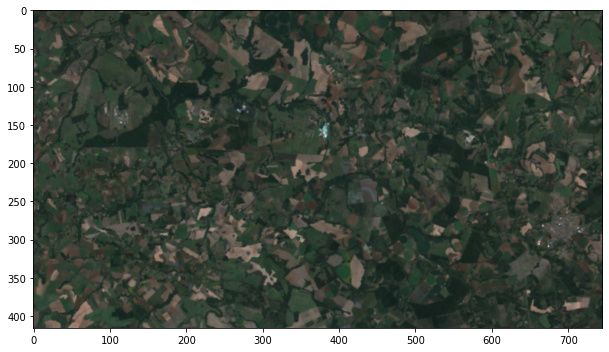

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(raster.getRGB())
plt.tight_layout()

plt.show()

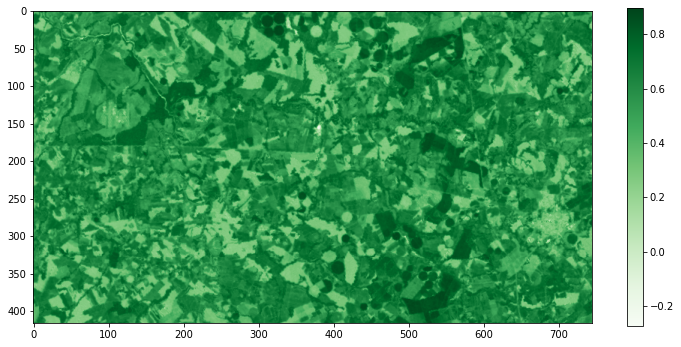

In [10]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(
    raster.getNDVI(),
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()